In [1]:
# Import necessary packages. 
from popstar import synthetic, evolution, atmospheres, reddening, ifmr
from popstar.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb
import os
import pylab as py
import astropy.modeling
from astropy.table import Table, Column, MaskedColumn
from random import choice
import time

/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /g/lu/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /g/lu/models/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [16]:
class MultiplicityResolvedDK(multiplicity.MultiplicityUnresolved):
    """
    Sub-class of MultiplicityUnresolved that adds semimajor axis and eccentricity information for multiple objects
    """
    def __init__(self, a_amp = 379.79953034, a_break = 4.90441533, a_slope1 = -1.80171539, 
                 a_slope2 = 4.23325571, a_std_slope = 1.19713084, a_std_intercept = 1.28974264, **kwargs):
        super(MultiplicityResolvedDK, self).__init__(**kwargs)
        self.a_amp = a_amp
        self.a_break = a_break
        self.a_slope1 = a_slope1
        self.a_slope2 = a_slope2
        self.a_std_slope = a_std_slope
        self.a_std_intercept = a_std_intercept
    
    def log_semimajoraxis(self, mass):
        """
        Generate the semimajor axis for a given mass. The mean and standard deviation of a given mass are determined 
        by fitting the data from fitting the semimajor axis data as a function of mass in table 1 of Duchene and Krauss 2013.
        Then a random semimajor axis is drawn from a log normal distribution with that mean and standard deviation.
        """
        a_mean_func = astropy.modeling.powerlaws.BrokenPowerLaw1D(amplitude=self.a_amp, x_break=self.a_break, alpha_1=self.a_slope1, alpha_2=self.a_slope2)
        log_a_mean = np.log10(a_mean_func(mass)) #mean log(a)
        log_a_std_func = astropy.modeling.models.Linear1D(slope=self.a_std_slope, intercept=self.a_std_intercept)
        log_a_std = log_a_std_func(np.log10(mass)) #sigma_log(a)
        if mass >= 2.9:
            log_a_std = log_a_std_func(np.log10(2.9)) #sigma_log(a)
        
        log_semimajoraxis = np.random.normal(log_a_mean, log_a_std)
        while 10**log_semimajoraxis > 2000 or 10**log_semimajoraxis < 0.25: #AU
            log_semimajoraxis = np.random.normal(log_a_mean, log_a_std)
            
        return log_semimajoraxis
    
    def random_e(self, x):
        """
        Generate random eccentricity from the inverse of the CDF where the PDF is f(e) = 2e from Duchene and Krauss 2013
        """
        e = np.sqrt(x)
        
        return e
    
    def random_keplarian_parameters(self, x, y, z):
        """
        Generate random incliniation and angles of binary system
        """
        sign = np.array([choice([-1,1]) for i in range(len(x))])
        x = sign*x
        inclination = np.arccos(x)*180/np.pi #inclination angle in degrees
        
        Omega = 360*y
        omega = 360*z
        
        return inclination, Omega, omega

In [3]:
class ResolvedCluster_ResolvedMult(synthetic.ResolvedCluster):
    """
    Sub-class of ResolvedCluster that adds semimajor axis info to the companions table
    
    Parameters
    -----------
    iso: isochrone object
        PyPopStar isochrone object
    
    imf: imf object
        PyPopStar IMF object

    cluster_mass: float
        Total initial mass of the cluster, in M_sun

    ifmr: ifmr object or None
        If ifmr object is defined, will create compact remnants
        produced by the cluster at the given isochrone age. Otherwise,
        no compact remnants are produced.

    seed: int
        If set to non-None, all random sampling will be seeded with the
        specified seed, forcing identical output.
        Default None

    vebose: boolean
        True for verbose output.
    """
    
    def __init__(self, iso, imf, cluster_mass,
                 ifmr=None, verbose=False, seed=None):

        synthetic.ResolvedCluster.__init__(self, iso, imf, cluster_mass, ifmr=ifmr, verbose=verbose,
                                     seed=seed)        
        if self.imf.make_multiples:
            N_comp_tot = self.star_systems['N_companions'].sum()
            
            self.companions.add_column( Column(np.zeros(N_comp_tot, dtype=float), name='log_a', description = 'degrees') )
            self.companions.add_column( Column(np.zeros(N_comp_tot, dtype=float), name='e') )
            self.companions.add_column( Column(np.zeros(N_comp_tot, dtype=float), name='i') )
            self.companions.add_column( Column(np.zeros(N_comp_tot, dtype=float), name='Omega') )
            self.companions.add_column( Column(np.zeros(N_comp_tot, dtype=float), name='omega') )
        
            for ii in range(len(self.companions)):
                self.companions['log_a'][ii] = self.imf._multi_props.log_semimajoraxis(self.star_systems['mass'][self.companions['system_idx'][ii]])
            
            self.companions['e'] = self.imf._multi_props.random_e(np.random.rand(N_comp_tot))
            self.companions['i'], self.companions['Omega'], self.companions['omega'] = self.imf._multi_props.random_keplarian_parameters(np.random.rand(N_comp_tot),np.random.rand(N_comp_tot),np.random.rand(N_comp_tot))

            
        return
            

In [4]:
# Fetch isochrone
logAge = 6.70 # Age in log(years)
AKs = 1.0 # Ks filter extinction in mags
dist = 4000 # distance in parsecs
metallicity = 0 # metallicity in [M/H]
atm_func = atmospheres.get_merged_atmosphere
evo_merged = evolution.MISTv1()
redlaw = reddening.RedLawCardelli(3.1) # Rv = 3.1
filt_list = ['nirc2,J', 'nirc2,Kp']

iso_dir = 'iso_merged_r1/'

if not os.path.exists(iso_dir):
        os.mkdir(iso_dir)

iso_merged = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=metallicity,
                                 evo_model=evo_merged, atm_func=atm_func,
                                 filters=filt_list, red_law=redlaw,
                                 iso_dir=iso_dir, mass_sampling=3)

Changing to logg=4.00 for T= 31319 logg=3.99
Changing to logg=4.00 for T= 32012 logg=3.95
Changing to logg=4.00 for T= 32586 logg=3.90
Changing to logg=4.00 for T= 33107 logg=3.84
Changing to logg=4.00 for T= 33284 logg=3.81
Changing to logg=4.00 for T= 33336 logg=3.79
Changing to logg=4.00 for T= 33406 logg=3.78
Changing to logg=4.00 for T= 33350 logg=3.72
Changing to logg=4.00 for T= 33249 logg=3.68
Changing to logg=4.00 for T= 33013 logg=3.64
Changing to logg=4.00 for T= 32774 logg=3.61
Changing to logg=4.00 for T= 32504 logg=3.57
Changing to logg=4.00 for T= 31785 logg=3.50
Changing to logg=4.00 for T= 31100 logg=3.44
Changing to logg=3.50 for T= 29991 logg=3.33
Changing to logg=3.50 for T= 28921 logg=3.23
Changing to logg=3.50 for T= 28170 logg=3.17
Changing to logg=3.50 for T= 27430 logg=3.10
Changing to logg=3.50 for T= 26705 logg=3.04
Changing to logg=3.50 for T= 26477 logg=3.00
Changing to logg=3.50 for T= 27177 logg=3.04
Changing to logg=3.50 for T= 27919 logg=3.09
Changing t

In [17]:
# Now we can make the cluster. 
clust_mtot = 10**4.
clust_multiplicity = MultiplicityResolvedDK()

# Multiplicity is defined in the IMF object
clust_imf_Mult = imf.Kroupa_2001(multiplicity=clust_multiplicity)

In [18]:
# Make clusters
clust_Mult = ResolvedCluster_ResolvedMult(iso_merged, clust_imf_Mult, clust_mtot)

clust_Mult_ss = clust_Mult.star_systems

(array([ 35.,  98., 140., 211., 282., 332., 378., 434., 457., 532.]),
 array([0.01402226, 0.1126027 , 0.21118315, 0.3097636 , 0.40834404,
        0.50692449, 0.60550493, 0.70408538, 0.80266582, 0.90124627,
        0.99982671]),
 <a list of 10 Patch objects>)

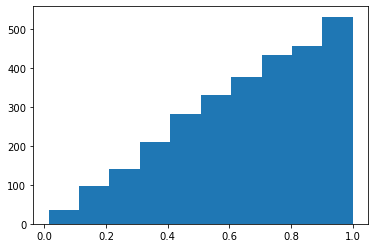

In [7]:
py.hist(clust_Mult.companions['e'])

(array([ 77., 202., 320., 408., 452., 426., 390., 323., 215.,  86.]),
 array([  0.76913283,  18.46054298,  36.15195313,  53.84336328,
         71.53477344,  89.22618359, 106.91759374, 124.60900389,
        142.30041404, 159.99182419, 177.68323434]),
 <a list of 10 Patch objects>)

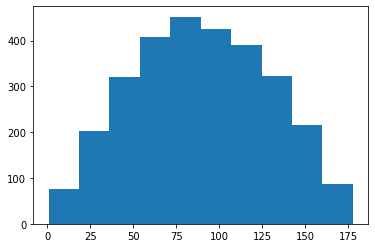

In [8]:
py.hist(clust_Mult.companions['i'])

In [47]:
def test_resolvedmult():  
    # Fetch isochrone
    logAge = 6.70 # Age in log(years)
    AKs = 1.0 # Ks filter extinction in mags
    dist = 4000 # distance in parsecs
    metallicity = 0 # metallicity in [M/H]
    atm_func = atmospheres.get_merged_atmosphere
    evo_merged = evolution.MISTv1()
    redlaw = reddening.RedLawCardelli(3.1) # Rv = 3.1
    filt_list = ['nirc2,J', 'nirc2,Kp']
    
    startTime = time.time()

    iso_merged = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=metallicity,
                                 evo_model=evo_merged, atm_func=atm_func,
                                 filters=filt_list, red_law=redlaw, mass_sampling=3)
    print('Constructed isochrone: %d seconds' % (time.time() - startTime))
    
    # Now we can make the cluster. 
    clust_mtot = 10**4.
    clust_multiplicity = MultiplicityResolvedDK()

    # Multiplicity is defined in the IMF object
    clust_imf_Mult = imf.Kroupa_2001(multiplicity=clust_multiplicity)
    
    # Make clusters
    clust_Mult = ResolvedCluster_ResolvedMult(iso_merged, clust_imf_Mult, clust_mtot)

    clust_Mult_ss = clust_Mult.star_systems
    
    print('Constructed cluster: %d seconds' % (time.time() - startTime))
    
    #check if columns were created
    assert 'log_a' in clust_Mult.companions.colnames
    assert 'e' in clust_Mult.companions.colnames
    assert 'i' in clust_Mult.companions.colnames
    assert 'Omega' in clust_Mult.companions.colnames
    assert 'omega' in clust_Mult.companions.colnames
    
    #check values are in correct range
    assert all(10**i<= 2000 and 10**i>= 0.25 for i in clust_Mult.companions['log_a']) #max separation is 1500 AU
    assert all(i<= 1 and i>= 0 for i in clust_Mult.companions['e'])
    assert all(i<= 180 and i>= 0 for i in clust_Mult.companions['i'])
    assert all(i<= 360 and i>= 0 for i in clust_Mult.companions['omega'])
    assert all(i<= 360 and i>= 0 for i in clust_Mult.companions['Omega'])
    
    #checks sign for inclination is being randomly genarated
    assert any(i > 90 for i in clust_Mult.companions['i']) and any(i < 90 for i in clust_Mult.companions['i'])
    
    #checks eccentricity follows f(e) = 2e pdf
    n, bins = np.histogram(clust_Mult.companions['e'], density = True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    assert all(np.abs(i) < 0.3 for i in 2*bin_centers - n)
    
    #checks shape of inclination histogram is sin(i)
    n, bins = np.histogram(clust_Mult.companions['i'])
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    #py.plot(bin_centers, n/max(n))
    #py.plot(bin_centers, np.sin(np.pi*bin_centers/180))
    sin_diff = n/max(n) - np.sin(np.pi*bin_centers/180)
    assert all(np.abs(i) < 0.15 for i in sin_diff.tolist())
    
    return

In [48]:
test_resolvedmult()

Changing to logg=4.00 for T= 31319 logg=3.99
Changing to logg=4.00 for T= 32012 logg=3.95
Changing to logg=4.00 for T= 32586 logg=3.90
Changing to logg=4.00 for T= 33107 logg=3.84
Changing to logg=4.00 for T= 33284 logg=3.81
Changing to logg=4.00 for T= 33336 logg=3.79
Changing to logg=4.00 for T= 33406 logg=3.78
Changing to logg=4.00 for T= 33350 logg=3.72
Changing to logg=4.00 for T= 33249 logg=3.68
Changing to logg=4.00 for T= 33013 logg=3.64
Changing to logg=4.00 for T= 32774 logg=3.61
Changing to logg=4.00 for T= 32504 logg=3.57
Changing to logg=4.00 for T= 31785 logg=3.50
Changing to logg=4.00 for T= 31100 logg=3.44
Changing to logg=3.50 for T= 29991 logg=3.33
Changing to logg=3.50 for T= 28921 logg=3.23
Changing to logg=3.50 for T= 28170 logg=3.17
Changing to logg=3.50 for T= 27430 logg=3.10
Changing to logg=3.50 for T= 26705 logg=3.04
Changing to logg=3.50 for T= 26477 logg=3.00
Changing to logg=3.50 for T= 27177 logg=3.04
Changing to logg=3.50 for T= 27919 logg=3.09
Changing t